In [1]:
%matplotlib widget

import inspect
import re
def debugPrint(x):
    frame = inspect.currentframe().f_back
    s = inspect.getframeinfo(frame).code_context[0]
    r = re.search(r"\((.*)\)", s).group(1)
    print("{} [{}] = {}".format(r,type(x).__name__, x))
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import TqdmExperimentalWarning
import warnings
warnings.filterwarnings(action='once')
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import torch
import matplotlib.patches as patches
import math
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib


# neighborSearch, neighborSearchFixed
# from torchCompactRadius.util import volumeToSupport
# from torchCompactRadius.neighborhood import neighborSearch

In [2]:
import torchCompactRadius as tcr
from torchCompactRadius import neighborSearch, neighborSearchExisting, volumeToSupport
# from torchCompactRadius.util import volumeToSupport

In [3]:
import torch

combinations = torch.combinations(torch.arange(-1,2), r=1, with_replacement = True)
print(combinations)



# torch.cartesian_prod(*t).view(-1,repeats)

tensor([[-1],
        [ 0],
        [ 1]])


In [4]:
# product(torch.arange(-1,2), repeat = 1)

In [5]:
import platform
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if platform.system() == 'Darwin':
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device = torch.device('cpu')
targetNumNeighbors = 50
hashMapLength = 4096
nx = 32
dim = 2

minDomain = torch.tensor([-1] * dim, dtype = torch.float32, device = device)
maxDomain = torch.tensor([ 1] * dim, dtype = torch.float32, device = device)
maxDomain[0] = 2
periodicity = [True] * dim

extent = maxDomain - minDomain
shortExtent = torch.min(extent, dim = 0)[0].item()
dx = (shortExtent / nx)
ny = int(1 // dx)
h = volumeToSupport(dx**dim, 50, dim)
dy = dx

print("minDomain = ", minDomain)
print("maxDomain = ", maxDomain)
print("extent = ", extent)
print("shortExtent = ", shortExtent)
print("dx = ", dx)
print("nx = ", nx)
print("dy = ", dy)
print("ny = ", ny)
print("h = ", h)
print("periodicity = ", periodicity)
print("device = ", device)
print("targetNumNeighbors = ", targetNumNeighbors)
print("hashMapLength = ", hashMapLength)


minDomain =  tensor([-1., -1.])
maxDomain =  tensor([2., 1.])
extent =  tensor([3., 2.])
shortExtent =  2.0
dx =  0.0625
nx =  32
dy =  0.0625
ny =  16
h =  0.24933892525089543
periodicity =  [True, True]
device =  cpu
targetNumNeighbors =  50
hashMapLength =  4096


In [6]:
nx

32

In [7]:
positions = []
for d in range(dim):
    positions.append(torch.linspace(minDomain[d] + dx / 2, maxDomain[d] - dx / 2, int((extent[d] - dx) / dx) + 1, device = device))
grid = torch.meshgrid(*positions, indexing = 'xy')
positions = torch.stack(grid, dim = -1).reshape(-1,dim).to(device)
# enable for random positions for alternative debugging
# positions = (torch.rand(nx**dim, dim) * 2 - 1).to(device)

supports = torch.ones(positions.shape[0], device = device) * h

print("positions.shape = ", positions.shape)
print("supports.shape = ", supports.shape)


positions.shape =  torch.Size([1536, 2])
supports.shape =  torch.Size([1536])


In [8]:
ypositions = []
for d in range(dim):
    ypositions.append(torch.linspace(-0.5 + dy / 2, 0.5 - dy / 2, ny, device = device))
grid = torch.meshgrid(*ypositions, indexing = 'xy')
y = torch.stack(grid, dim = -1).reshape(-1,dim).to(device)


# ypos2 = torch.linspace(-0.5 + dy / 2, 0.5 - dy / 2, ny)
# xpos2, ypos2 = torch.meshgrid(xpos2, ypos2, indexing = 'xy')
# y = torch.stack((xpos2.flatten(), ypos2.flatten()), dim = 1).to(device)
# y = torch.clone(positions)
ySupport = torch.ones(y.shape[0], device = device) * supports[0]

print("y.shape = ", y.shape)
print("ySupport.shape = ", ySupport.shape)

y.shape =  torch.Size([256, 2])
ySupport.shape =  torch.Size([256])


In [9]:
from torchCompactRadius.util import hashCellIndices_cpp, linearIndexing, hashCellIndices

# indices = torch.floor((positions - (minDomain).to(positions.device)) / hCell).to(torch.int32)
# linearIndices = linearIndexing(indices, numCells) #indices[:,0] + cellCount[0] * indices[:,1]
# cellIndices, cellCounters = torch.unique_consecutive(linearIndices, return_counts=True, return_inverse=False)

# print('indices', indices)

hashedIndices = hashCellIndices(torch.tensor([[0,0], [1,0], [2,0]]), hashMapLength)
print('hashed indices (python | cpu)', hashedIndices.detach().cpu().numpy())

hashed indices (python | cpu) [   0 1117 2234]


In [10]:
# (i_cpu, j_cpu), ni_cpu, nj_cpu, *_ = neighborSearch((positions, y), (supports, ySupport), (minDomain, maxDomain), periodicity, hashMapLength, 'symmetric', 'python')
# (i_cpu, j_cpu), ni_cpu, nj_cpu, *_ = neighborSearch((positions, y), h, (minDomain, maxDomain), periodicity, hashMapLength, 'symmetric', 'python')

# (i_cpu, j_cpu), ni_cpu, nj_cpu, *_ = neighborSearch((positions, y), (supports, ySupport), (minDomain, maxDomain), periodicity, hashMapLength, 'symmetric', 'pythonDynamic')
# (i_cpu, j_cpu), ni_cpu, nj_cpu, *_ = neighborSearch((positions, y), h, (minDomain, maxDomain), periodicity, hashMapLength, 'symmetric', 'pythonDynamic')

In [11]:
# sortedPositions, sortedSupports, hashTable, sortedCellTable, hCell, qMin, qMax, numCells, sortIndex = _

In [12]:
# (i_cpu, j_cpu), ni_cpu, nj_cpu, *_ = tcr.neighborSearch((positions, y), (supports, ySupport), (minDomain, maxDomain), periodicity, hashMapLength, 'symmetric', 'cpp')
# (i_cpu, j_cpu), ni_cpu, nj_cpu, *_ = tcr.neighborSearch((positions, y), h, (minDomain, maxDomain), periodicity, hashMapLength, 'symmetric', 'cpp')
# (i_cpu, j_cpu), ni_cpu, nj_cpu, *_ = tcr.neighborSearch(positions, (supports, supports), (minDomain, maxDomain), periodicity, hashMapLength = hashMapLength, mode = 'symmetric', variant = 'cpp', verbose = False)
# (i_cpu, j_cpu), ni_cpu, nj_cpu, *_ = tcr.neighborSearch(positions, h, (minDomain, maxDomain), periodicity, hashMapLength = hashMapLength, mode = 'symmetric', variant = 'cpp')
# (i_cpu, j_cpu), ni_cpu, nj_cpu, *_ = tcr.neighborSearch(positions, (supports, supports), (minDomain, maxDomain), hashMapLength = hashMapLength, mode = 'symmetric', variant = 'cpp', verbose = False)
# (i_cpu, j_cpu), ni_cpu, nj_cpu, *_ = tcr.neighborSearch(positions, h, (minDomain, maxDomain), hashMapLength = hashMapLength, mode = 'symmetric', variant = 'cpp')
# (i_cpu, j_cpu), ni_cpu, nj_cpu, *_ = tcr.neighborSearch(positions, (supports, supports), hashMapLength = hashMapLength, mode = 'symmetric', variant = 'cpp', verbose = False)
# (i_cpu, j_cpu), ni_cpu, nj_cpu, *_ = tcr.neighborSearch(positions, h, hashMapLength = hashMapLength, mode = 'symmetric', variant = 'cpp')

In [13]:
# countNeighbors(queryPositions[index,:], queryParticleSupports[index] if queryParticleSupports is not None else None, searchRadius, sortedPositions, sortedSupports, hashTable, hashMapLength, numCells, sortedCellTable, qMin, hCell, maxD, minD, torch.tensor(periodicity), mode)

In [14]:
# torch._dynamo.reset()
# compiled = torch.compile(neighborSearch, backend='inductor',
#                               options={'trace.enabled':True,
#                                        'trace.graph_diagram':True})
# (i_cpu, j_cpu), ni_cpu, nj_cpu, sortedPositions, sortedSupports, hashTable, sortedCellTable, hCell, qMin, qMax, numCells, sortIndex = compiled((y, positions), (ySupport, supports), (minDomain, maxDomain), periodicity, hashMapLength, 'symmetric', 'pythonDynamic')

In [24]:
(i_cpu, j_cpu), ni_cpu, nj_cpu, neighborDict = \
     neighborSearch((y, positions), (ySupport, supports), (minDomain, maxDomain), periodicity, hashMapLength, 'symmetric', 'python')
# (i_cpu, j_cpu), ni_cpu, nj_cpu = \
     # neighborSearchExisting(y, ySupport, neighborDict, mode = 'symmetric', variant = 'python')

In [16]:
(i_cpu, j_cpu), ni_cpu, nj_cpu, neighborDict = \
     neighborSearch((y, positions), (ySupport, supports), (minDomain, maxDomain), periodicity, hashMapLength, 'symmetric', 'cpp')
(i_cpu, j_cpu), ni_cpu, nj_cpu = \
     neighborSearchExisting(y, ySupport, neighborDict, mode = 'symmetric', variant = 'cpp')

In [25]:
print('i_cpu', i_cpu.device, i_cpu.dtype, i_cpu.shape, i_cpu)
print('j_cpu', j_cpu.device, j_cpu.dtype, j_cpu.shape, j_cpu)
print('ni_cpu', ni_cpu.device, ni_cpu.dtype, ni_cpu.shape, ni_cpu)
print('nj_cpu', nj_cpu.device, nj_cpu.dtype, nj_cpu.shape, nj_cpu)
print('sortedPositions', neighborDict['sortedPositions'].device, neighborDict['sortedPositions'].dtype, neighborDict['sortedPositions'].shape, neighborDict['sortedPositions'])
print('sortedSupports', neighborDict['sortedSupports'].device, neighborDict['sortedSupports'].dtype, neighborDict['sortedSupports'].shape, neighborDict['sortedSupports'])
print('hashTable', neighborDict['hashTable'].device, neighborDict['hashTable'].dtype, neighborDict['hashTable'].shape, neighborDict['hashTable'])
print('sortedCellTable', neighborDict['sortedCellTable'].device, neighborDict['sortedCellTable'].dtype, neighborDict['sortedCellTable'].shape, neighborDict['sortedCellTable'])
print('qMin', neighborDict['qMin'].device, neighborDict['qMin'].dtype, neighborDict['qMin'].shape, neighborDict['qMin'])
print('qMax', neighborDict['qMax'].device, neighborDict['qMax'].dtype, neighborDict['qMax'].shape, neighborDict['qMax'])
print('numCells', neighborDict['numCells'].device, neighborDict['numCells'].dtype, neighborDict['numCells'].shape, neighborDict['numCells'])
print('sortIndex', neighborDict['sortIndex'].device, neighborDict['sortIndex'].dtype, neighborDict['sortIndex'].shape, neighborDict['sortIndex'])


i_cpu cpu torch.int64 torch.Size([11520]) tensor([  0,   0,   0,  ..., 255, 255, 255])
j_cpu cpu torch.int64 torch.Size([11520]) tensor([ 343,  342,  341,  ..., 1177, 1178, 1273])
ni_cpu cpu torch.int64 torch.Size([256]) tensor([45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
        45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45,

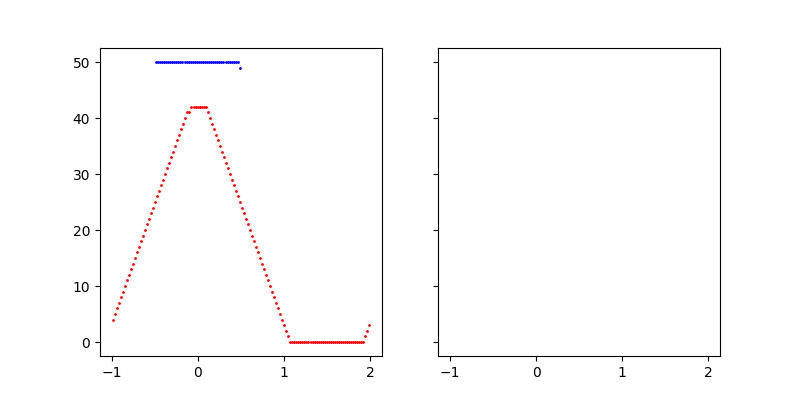

In [28]:

fig, axis = plt.subplots(1,2, figsize=(8,4), sharex = True, sharey = True, squeeze = False)

axis[0,0].scatter(positions[:,0].cpu(), nj_cpu.cpu(), s = 1, c = 'r')
axis[0,0].scatter(y[:,0].cpu(), ni_cpu.cpu(), s = 1, c = 'b')

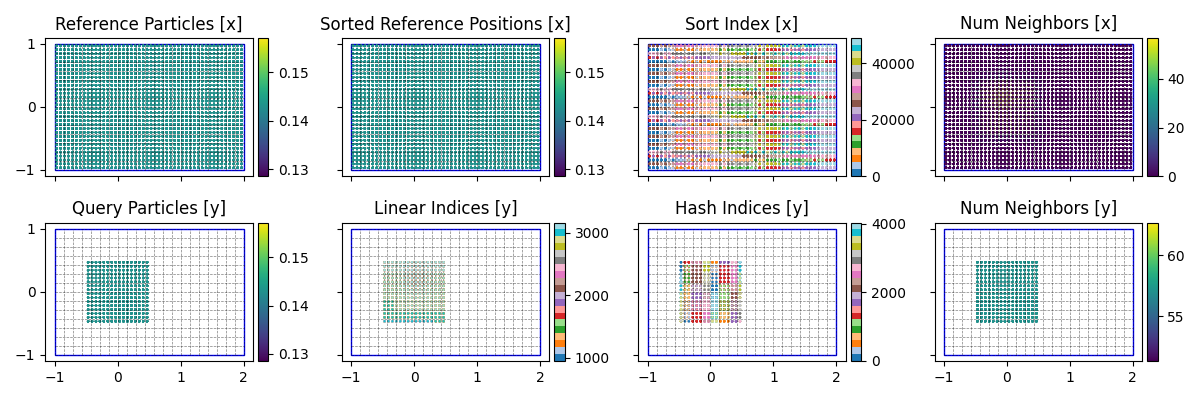

In [19]:
def plotGrid(ax, qMin, qMax, hCell, numCells):
    ax.add_patch(patches.Rectangle((qMin[0].detach().cpu(), qMin[1].detach().cpu()), (qMax[0] - qMin[0]).detach().cpu(), (qMax[1] - qMin[1]).detach().cpu(), fill=False, edgecolor='b', linewidth = 1))
    for i in range(numCells[0].detach().cpu() + 1):
        ax.vlines(x = qMin[0].detach().cpu() + i * hCell, ymin = qMin[1].detach().cpu(), ymax = qMax[1].detach().cpu(), color = 'black', linestyle = '--', alpha = 0.5, lw = 0.5)
    for i in range(numCells[1].detach().cpu() + 1): 
        ax.hlines(y = qMin[1].detach().cpu() + i * hCell, xmin = qMin[0].detach().cpu(), xmax = qMax[0].detach().cpu(), color = 'black', linestyle = '--', alpha = 0.5, lw = 0.5)
    ax.set_aspect(1, adjustable='box')

def scatterPlot(fig, ax, positions, c, scatterSize, title, cmap = 'viridis', norm = 'linear', midPoint = 0):
    if norm == 'log':
        dataNorm = matplotlib.colors.LogNorm(vmin = c.min(), vmax = c.max())
    elif norm == 'sym':
        dataNorm = matplotlib.colors.Normalize(vmin = midPoint - (midPoint - c).abs().max(), vmax = midPoint + (midPoint - c).abs().max())
    else:
        dataNorm = matplotlib.colors.Normalize(vmin = c.min(), vmax = c.max())

    sc = ax.scatter(positions[:,0].detach().cpu(), positions[:,1].detach().cpu(), c = c.detach().cpu(), s = scatterSize, label = title, cmap = cmap, norm = dataNorm)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)    
    plt.colorbar(sc, cax=cax)
    ax.set_title(title)


fig, axis = plt.subplots(2, 4, figsize=(12,4), sharex = True, sharey = True, squeeze = False)

for ax in axis.flatten():
    plotGrid(ax, neighborDict['qMin'] , neighborDict['qMax'], neighborDict['hCell'], neighborDict['numCells'])
scatterSize = 100 / math.sqrt(positions.shape[0])

scatterPlot(fig, axis[0,0], positions, supports, scatterSize, 'Reference Particles [x]')
scatterPlot(fig, axis[0,1], neighborDict['sortedPositions'], neighborDict['sortedSupports'], scatterSize, 'Sorted Reference Positions [x]')
scatterPlot(fig, axis[1,0], y, ySupport, scatterSize, 'Query Particles [y]')

scatterPlot(fig, axis[0,2], positions, neighborDict['sortIndex'], scatterSize, 'Sort Index [x]', cmap = 'tab20', norm = 'linear')

from torchCompactRadius.util import linearIndexing, hashCellIndices

cellIndices = torch.floor((y - neighborDict['qMin']) / neighborDict['hCell']).to(torch.int32)
linearIndices = linearIndexing(cellIndices, neighborDict['numCells'])
hashIndices = hashCellIndices(cellIndices, hashMapLength)
scatterPlot(fig, axis[1,1], y, linearIndices, scatterSize, 'Linear Indices [y]', cmap = 'tab20', norm = 'linear')
scatterPlot(fig, axis[1,2], y, hashIndices, scatterSize, 'Hash Indices [y]', cmap = 'tab20', norm = 'linear')

scatterPlot(fig, axis[0,3], positions, nj_cpu, scatterSize, 'Num Neighbors [x]')
scatterPlot(fig, axis[1,3], y, ni_cpu, scatterSize, 'Num Neighbors [y]')

fig.tight_layout()

In [14]:
from torchCompactRadius.util import hashCellIndices_cpp, linearIndexing, hashCellIndices

indices = torch.floor((positions - (minDomain).to(positions.device)) / hCell).to(torch.int32)
linearIndices = linearIndexing(indices, numCells) #indices[:,0] + cellCount[0] * indices[:,1]
cellIndices, cellCounters = torch.unique_consecutive(linearIndices, return_counts=True, return_inverse=False)

print('indices', indices[:16,:])
hashedCellIndices = hashCellIndices_cpp(indices[:16,:].to(torch.int32), hashMapLength)
for i in range(len(indices[:16,:])):
    print('cell', i, 'linear index', indices[i], 'hashed index', hashedCellIndices[i]) 

    
# hashedIndices = hashCellIndices(indices.to('cpu'), hashMapLength)
# print('hashed indices (python | cpu)', hashedIndices.detach().cpu().numpy())
# hashedIndices = hashCellIndices_cpp(indices.to(torch.int32).to('cpu'), hashMapLength)
# print('hashed indices (C++ | cpu)', hashedIndices.detach().cpu().numpy())

# hashedIndices = hashCellIndices(indices.to('cuda'), hashMapLength)
# print('hashed indices (python | gpu)', hashedIndices.detach().cpu().numpy())
# hashedIndices = hashCellIndices_cpp(indices.to('cuda'), hashMapLength)
# print('hashed indices (C++ | gpu)', hashedIndices.detach().cpu().numpy())

In [31]:

# hashedIndicesa = hashCellIndices(indices.to('cuda'), hashMapLength).to('cpu')
# hashedIndicesb = hashCellIndices_cpp(indices.to(torch.int32).to('cuda'), hashMapLength).to('cpu')

# print((hashedIndicesa - hashedIndicesb).sum())

tensor(0)


In [16]:
hashedCellIndices = hashCellIndices_cpp(indices[:16,:].to(torch.int32), hashMapLength)
for i in range(len(indices[:16,:])):
    print('cell', i, 'linear index', indices[i], 'hashed index', hashedCellIndices[i])

cell[0] = [0, 0] -> hashIndicesAccessor[0] = 0
cell[1] = [0, 0] -> hashIndicesAccessor[1] = 0
cell[2] = [0, 0] -> hashIndicesAccessor[2] = 0
cell[3] = [0, 0] -> hashIndicesAccessor[3] = 0
cell[4] = [1, 0] -> hashIndicesAccessor[4] = 1117
cell[5] = [1, 0] -> hashIndicesAccessor[5] = 1117
cell[6] = [1, 0] -> hashIndicesAccessor[6] = 1117
cell[7] = [1, 0] -> hashIndicesAccessor[7] = 1117
cell 0 linear index cell[8] = [2, 0] -> hashIndicesAccessor[8] = 2234
cell[9] = [2, 0] -> hashIndicesAccessor[9] = 2234
cell[10] = [2, 0] -> hashIndicesAccessor[10] = 2234
cell[11] = [2, 0] -> hashIndicesAccessor[11] = 2234
cell[12] = [3, 0] -> hashIndicesAccessor[12] = 3351
cell[13] = [3, 0] -> hashIndicesAccessor[13] = 3351
cell[14] = [3, 0] -> hashIndicesAccessor[14] = 3351
cell[15] = [3, 0] -> hashIndicesAccessor[15] = 3351
tensor([0, 0], dtype=torch.int32) hashed index tensor(0, dtype=torch.int32)
cell 1 linear index tensor([0, 0], dtype=torch.int32) hashed index tensor(0, dtype=torch.int32)
cell 2 l

In [31]:
hashedCellIndices = hashCellIndices(indices, hashMapLength)
for i in range(len(indices)):
    print('cell', i, 'linear index', indices[i], 'hashed index', hashedCellIndices[i])

cell 0 linear index tensor([0, 0], dtype=torch.int32) hashed index tensor(0, dtype=torch.int32)
cell 1 linear index tensor([0, 0], dtype=torch.int32) hashed index tensor(0, dtype=torch.int32)
cell 2 linear index tensor([0, 0], dtype=torch.int32) hashed index tensor(0, dtype=torch.int32)
cell 3 linear index tensor([0, 0], dtype=torch.int32) hashed index tensor(0, dtype=torch.int32)
cell 4 linear index tensor([1, 0], dtype=torch.int32) hashed index tensor(1117, dtype=torch.int32)
cell 5 linear index tensor([1, 0], dtype=torch.int32) hashed index tensor(1117, dtype=torch.int32)
cell 6 linear index tensor([1, 0], dtype=torch.int32) hashed index tensor(1117, dtype=torch.int32)
cell 7 linear index tensor([1, 0], dtype=torch.int32) hashed index tensor(1117, dtype=torch.int32)
cell 8 linear index tensor([2, 0], dtype=torch.int32) hashed index tensor(2234, dtype=torch.int32)
cell 9 linear index tensor([2, 0], dtype=torch.int32) hashed index tensor(2234, dtype=torch.int32)
cell 10 linear index t